# Particle rotation notebook 

This notebook demonstrates how the rotation of an asymmetric particle can make the particle appear as different shapes, and, if enough rotations are considered, will form a single circular structure.

To do this, I load a simple image, rotate it to a number, n, of random angles (theta) and add the images together. This process can be performed starting with the initial image each time, or rotating sequentially (which is the more realistic process). 

## Import dependancies

In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import random
plt.gray()

<Figure size 432x288 with 0 Axes>

## Load image

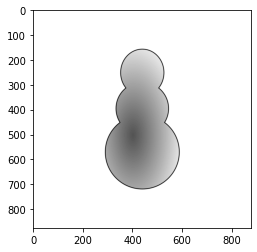

In [2]:
im = cv2.imread('Rotation_demo.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(im)
plt.show()

## Invert image 

When I rotate an image, the region region outside the image is by default black, the easiest way to fix this, considering I have a white background already is to invert the image. I will invert the image again at the end. 

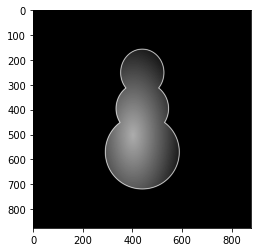

In [3]:
im = cv2.bitwise_not(im)
plt.imshow(im)
plt.show()

## Define Rotation


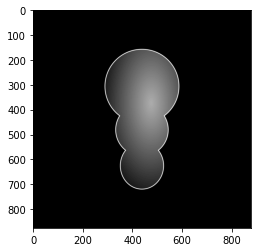

In [8]:
height, width = im.shape

centerX, centerY = (width // 2, height // 2) #setting the pivot to the centre of the image

M = cv2.getRotationMatrix2D((centerX, centerY), -180, 1.0) #Create rotation

rotated = cv2.warpAffine(im, M, (width, height)) # Rotate Image

plt.imshow(rotated)
plt.show()

## Randomise rotation

I want to make a random rotation value, ranging from zero to a defined value (`max_rotation`).

This could be done using random.randint(), but performing `random.random()*max_rotation` means it does not have to be an integer.

I'm also randomising if the rotation is positive or negative (clockwise or anticlockwise). 


In [5]:
max_rotation = 180
rotation = random.random()*max_rotation

if random.random()>0.5:
    rotation = -rotation

print(rotation)

140.37769606484


## Loop this n times and create a function

I'm doing non-sequentially and sequentially. By sequentially I mean that each rotation is made from the previous image. Non-sequentially on the other hand means that the rotation is made beginning from the initial image. 

In [18]:
n = 100
def create_rotations(n, max_rotation):
    rotated_ims = [im]
    for x in range(n):
        rotation = random.random()*max_rotation
        if random.random()>0.5:
            rotation = -rotation
        M = cv2.getRotationMatrix2D((centerX, centerY), rotation, 1.0)
        rotated = cv2.warpAffine(im, M, (width, height))
        
        rotated_ims.append(rotated)
    new_im = np.sum(np.array(rotated_ims), axis=0)
    new_im = cv2.bitwise_not(new_im)
    new_im = convert8bit(new_im) 
    
    return new_im

In [5]:
def create_rotations_sequential(n, max_rotation):
    rotated_ims = [im]
    for x in range(n):
        rotation = random.random()*max_rotation
        if random.random()>0.5:
            rotation = -rotation
        M = cv2.getRotationMatrix2D((centerX, centerY), rotation, 1.0)
        rotated = cv2.warpAffine(rotated_ims[-1], M, (width, height))
        
        rotated_ims.append(rotated)
    new_im = np.sum(np.array(rotated_ims), axis=0)
    new_im = cv2.bitwise_not(new_im)
    new_im = convert8bit(new_im) 
    
    return new_im

## Define convert to 8bit 

To save the images, the values need to range from 0-255, so this function performs this adjustment. This function also makes sure each image is on the same scale. 

In [10]:
def convert8bit(noisy_frames):
    frames8bit = (noisy_frames - noisy_frames.min()) * (
                1 / (noisy_frames.max() - noisy_frames.min()) * 255
            )
    return frames8bit

## Plot the results - Non-sequential


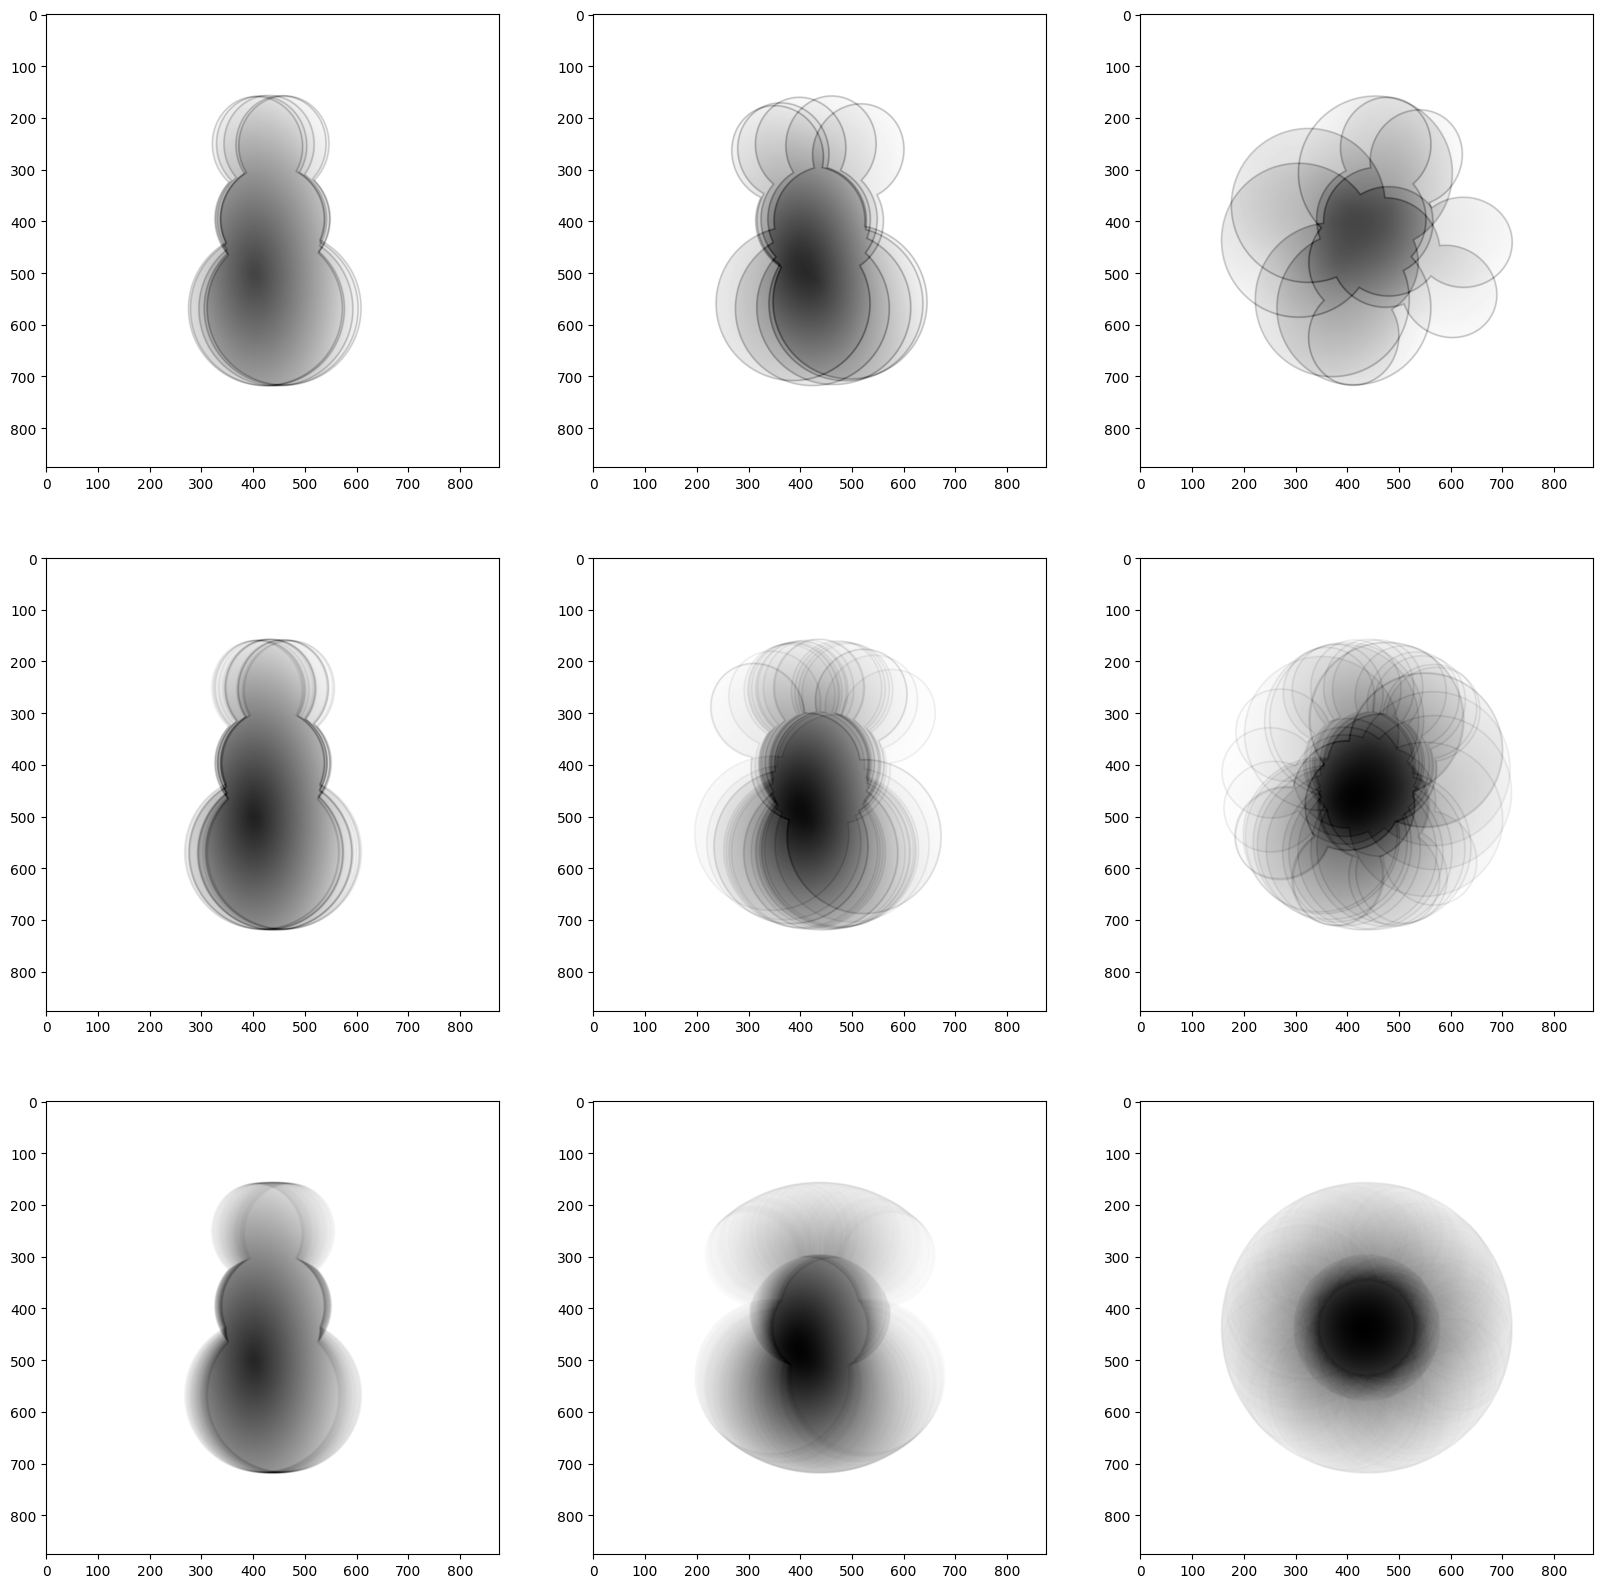

In [10]:
ns = [5, 20, 1000]
max_rotations = [10, 45, 180]

fig, axes = plt.subplots(3,3, figsize=(20,20))

for i, max in enumerate(max_rotations):
    axes[0][i].imshow(create_rotations(ns[0], max))
    axes[1][i].imshow(create_rotations(ns[1], max))
    axes[2][i].imshow(create_rotations(ns[2], max))

plt.show()

## Plot results - sequential

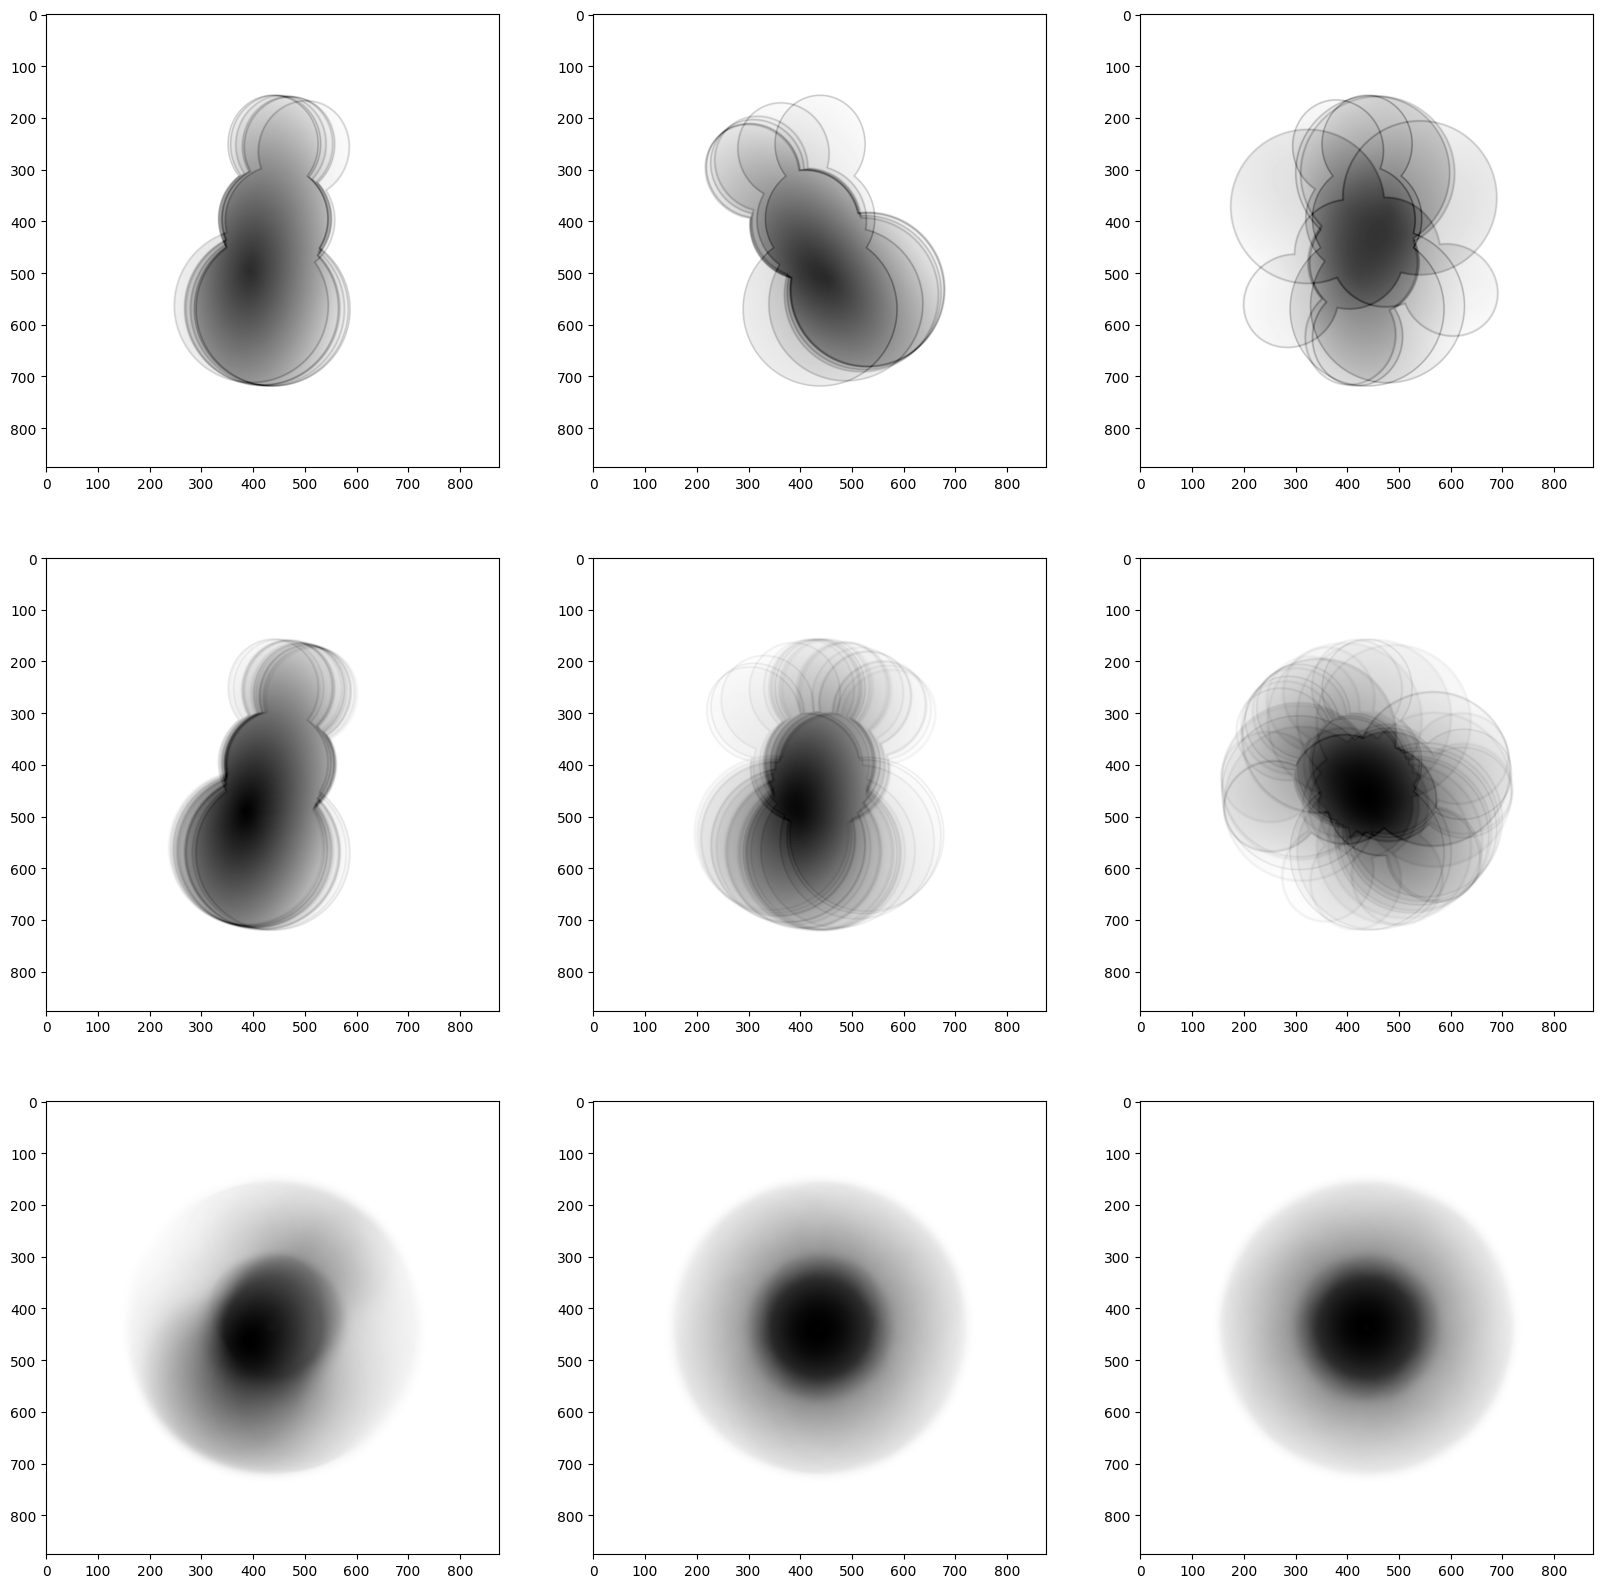

In [11]:
ns = [5, 20, 1000]
max_rotations = [10, 45, 180]

fig, axes = plt.subplots(3,3, figsize=(20,20))

for i, max in enumerate(max_rotations):
    axes[0][i].imshow(create_rotations_sequential(ns[0], max))
    axes[1][i].imshow(create_rotations_sequential(ns[1], max))
    axes[2][i].imshow(create_rotations_sequential(ns[2], max))

plt.show()

## Write the output images

In [25]:
cv2.imwrite('Image_rotation_1000_10.png', create_rotations(1000, 10))

True

In [45]:
for n in [5, 20, 1000]:
    cv2.imwrite(f'Image_rotation_{n}_10.png', create_rotations(n, 10))
    cv2.imwrite(f'Image_rotation_{n}_45.png', create_rotations(n, 45))
    cv2.imwrite(f'Image_rotation_{n}_180.png', create_rotations(n, 180))

In [47]:
for n in [5, 20, 1000]:
    cv2.imwrite(f'Sequential_Image_rotation_{n}_10.png', create_rotations_sequential(n, 10))
    cv2.imwrite(f'Sequential_Image_rotation_{n}_45.png', create_rotations_sequential(n, 45))
    cv2.imwrite(f'Sequential_Image_rotation_{n}_180.png', create_rotations_sequential(n, 180))

## What happens if you average together many rotated sums?

Lets say, hypothetically, that you had a large number of images of the same asymmetric particle that had rotated during imaging, giving a variety of shapes as seen above (particularly at low n values). Can you get the original image back? 

For this I am going to assume minimal rotation (+/- 2 degrees max) and non-sequential rotation. 

In the original function, included the original angle of the particle in the output. This means if n=10 it will return a sum of 10 random angles *and* the original angle. This provides an opportunity to average the results of many particles to regain resolution. This is comparable to perfectly aligning many blurred images, but may not be possible to produce without this knowledge of the original position.   

### n=10

The proportion of signal to blur (effectively noise) is 1/(n+1), as one copy of the original data is included. Summing multiple random blurred images of the particle will enhance the signal due to this small signal, this is similar to the 'Statistical noise, averaged picture' method used in cryo-EM and demonstrated in the notebook of that name on this github respository.   

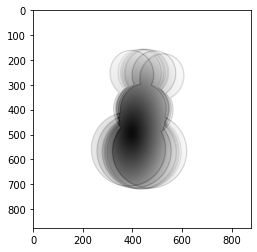

In [26]:
#Show rotated image (one random example of)
plt.imshow(create_rotations(10,30))
plt.show()

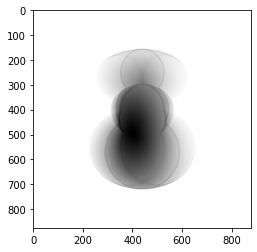

In [25]:
set_ims = []
for x in range(500):
    
    set_ims.append(create_rotations(10, 30))

new_im = np.sum(np.array(set_ims), axis=0)
new_im = convert8bit(new_im)
plt.imshow(new_im)
plt.show()

#cv2.imwrite('Sum_of_500rotations_5degrees_n10.png', new_im)

You can see the outline of original position being enhanced beneath the motion blur...


### n=30

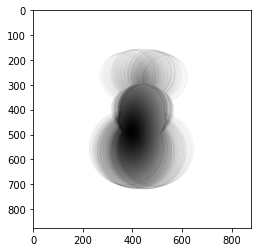

In [27]:
#Show rotated image (one random example of)
plt.imshow(create_rotations(30,30))
plt.show()

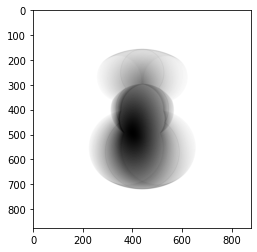

In [28]:
set_ims = []
for x in range(500):
    
    set_ims.append(create_rotations(30, 30))

new_im = np.sum(np.array(set_ims), axis=0)
new_im = convert8bit(new_im)
plt.imshow(new_im)
plt.show()


The outline is much weaker because the original position is only repeated exactly in 1/31 of the input data.

### n=3

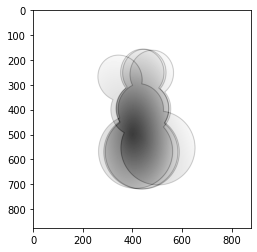

In [30]:
#Show rotated image (one random example of)
plt.imshow(create_rotations(3,30))
plt.show()

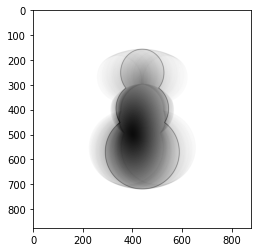

In [31]:
set_ims = []
for x in range(500):
    
    set_ims.append(create_rotations(3, 30))

new_im = np.sum(np.array(set_ims), axis=0)
new_im = convert8bit(new_im)
plt.imshow(new_im)
plt.show()


Here the enhancement is very noticable as the original position represents 25% of the output image.

Note that in all these examples, the more images that are added together the sharper the original image.

## What happens if the original image isn't included in the output? 
First edit the function: 

In [32]:
def create_rotations(n, max_rotation):
    #rotated_ims = [im]
    rotated_ims = [] ## The original image isnt included in the output in this version of the function
    for x in range(n):
        rotation = random.random()*max_rotation
        if random.random()>0.5:
            rotation = -rotation
        M = cv2.getRotationMatrix2D((centerX, centerY), rotation, 1.0)
        rotated = cv2.warpAffine(im, M, (width, height))
        
        rotated_ims.append(rotated)
    new_im = np.sum(np.array(rotated_ims), axis=0)
    new_im = cv2.bitwise_not(new_im)
    new_im = convert8bit(new_im) 
    
    return new_im

I'm going to start with n=3:

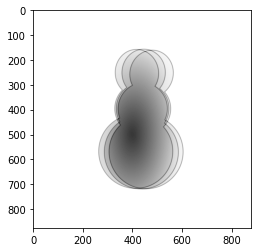

In [33]:
#Show rotated image (one random example of)
plt.imshow(create_rotations(3,30))
plt.show()

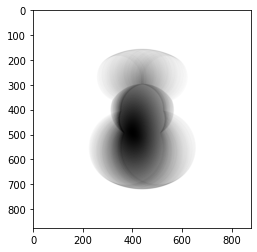

In [34]:
set_ims = []
for x in range(500):
    
    set_ims.append(create_rotations(3, 30))

new_im = np.sum(np.array(set_ims), axis=0)
new_im = convert8bit(new_im)
plt.imshow(new_im)
plt.show()

The motion blur is compounds rather than removes because none of the angles are replicated... 

## What happens if the pivot moves slightly?

For each rotation, I am going to move the pivot to a random point within +/- `pivot_variation` pixels from the centre point of the image and see if what effect it has on the visualised image

In [6]:

def create_rotations_variable_pivot(n, max_rotation, pivot_variation):
    rotated_ims = [im]
    for x in range(n):
        rotation = random.random()*max_rotation
        if random.random()>0.5:
            rotation = -rotation

        if random.random()>0.5:
            newCenterX= im.shape[0]//2+pivot_variation*random.random()
        else:
            newCenterX= im.shape[0]//2-pivot_variation*random.random()
        if random.random()>0.5:
            newCenterY= im.shape[1]//2+pivot_variation*random.random()
        else:
            newCenterY= im.shape[1]//2-pivot_variation*random.random()
        #print(centerX, centerY)
        #print(newCenterX, newCenterY)
        
        M = cv2.getRotationMatrix2D((newCenterX, newCenterY), rotation, 1.0)
        rotated = cv2.warpAffine(im, M, (width, height))
        
        rotated_ims.append(rotated)
    new_im = np.sum(np.array(rotated_ims), axis=0)
    new_im = cv2.bitwise_not(new_im)
    new_im = convert8bit(new_im) 
    
    return new_im

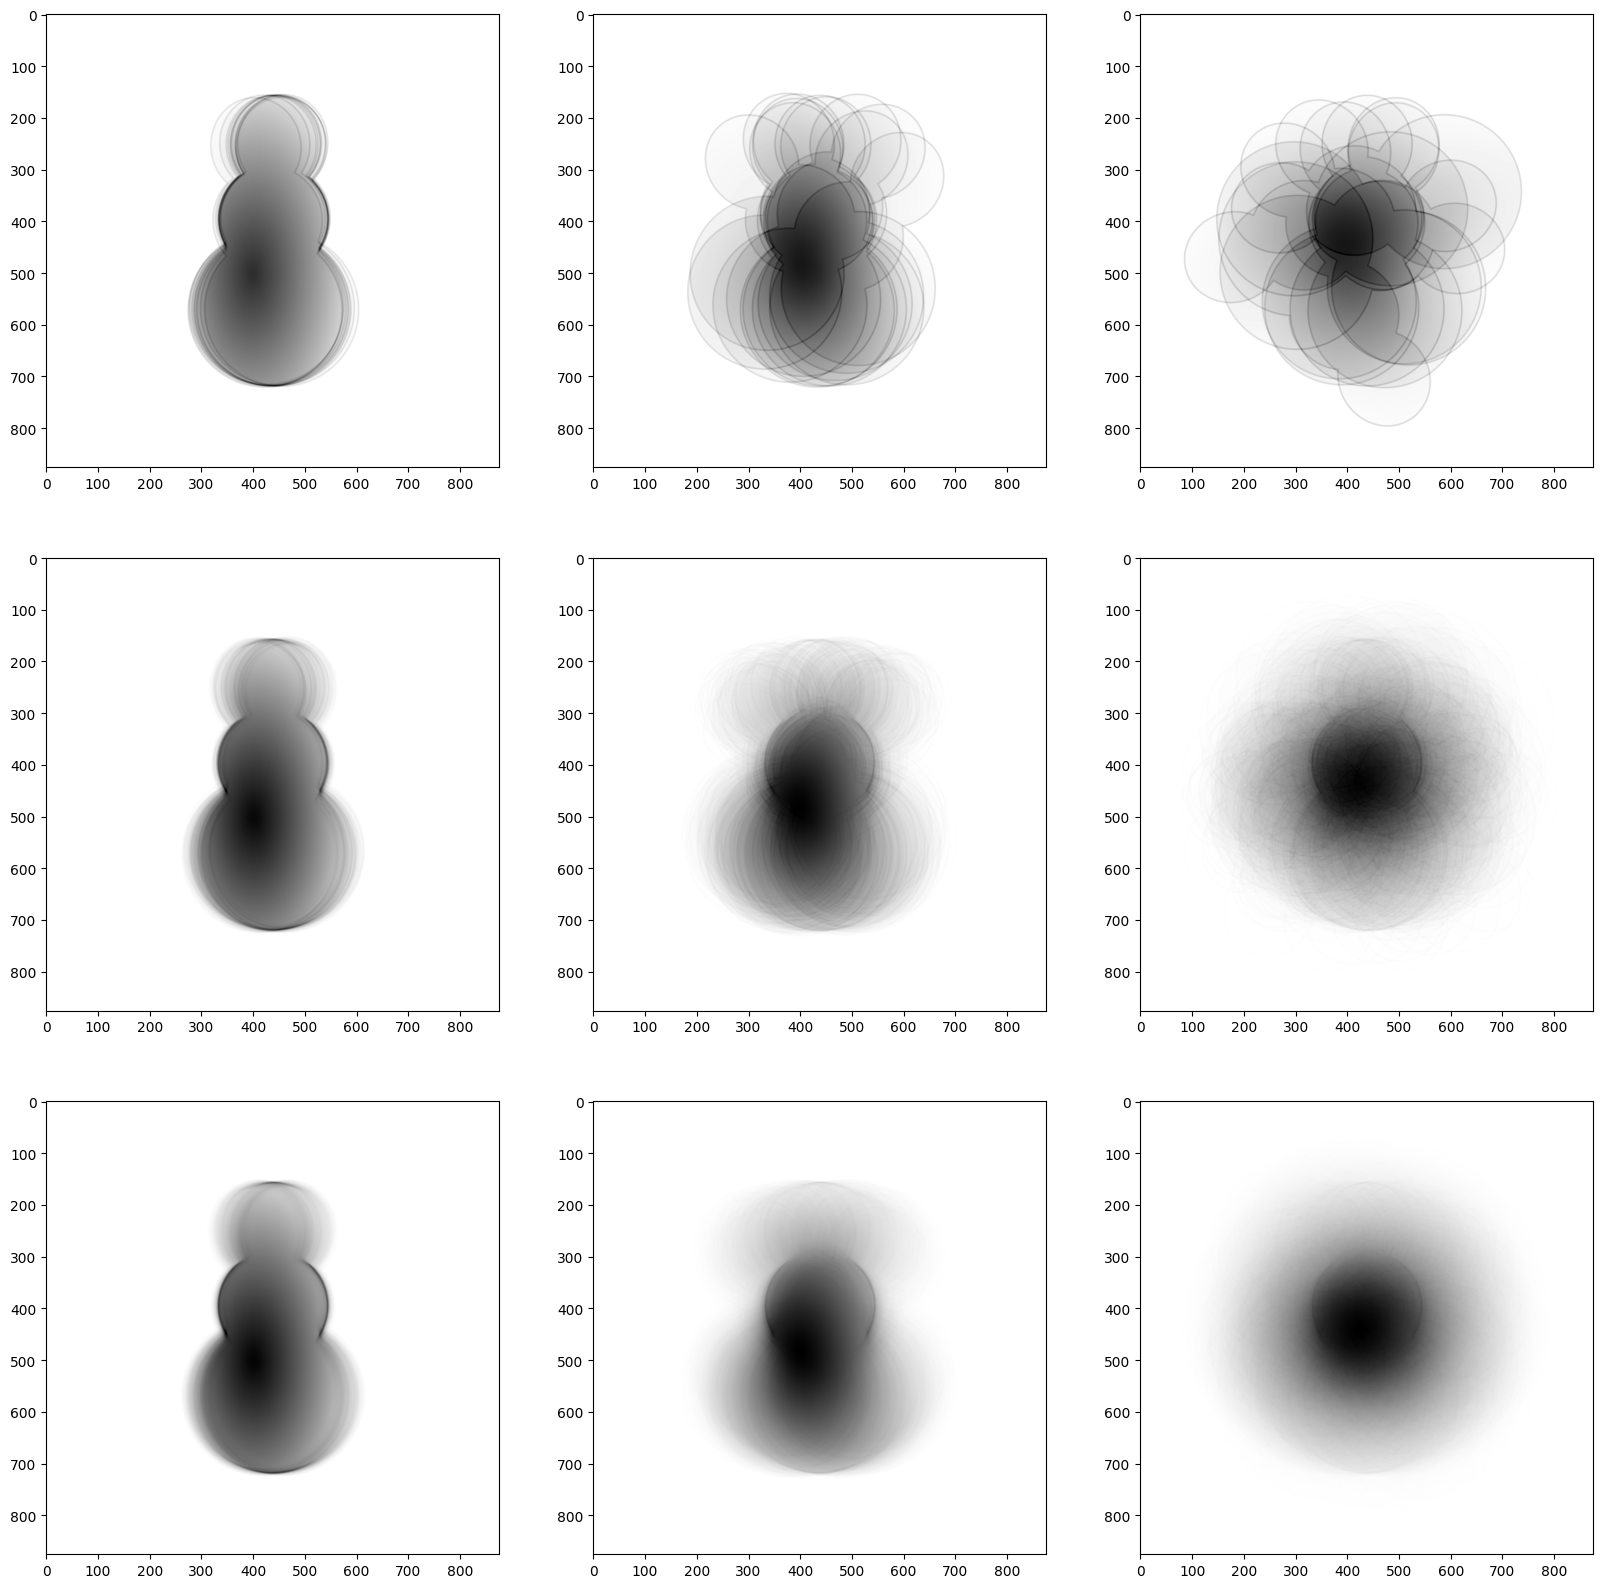

In [46]:
ns = [10, 200, 2000]
max_rotations = [10, 45, 180]

fig, axes = plt.subplots(3,3, figsize=(20,20))

for i, max in enumerate(max_rotations):
    axes[0][i].imshow(create_rotations_variable_pivot(ns[0], max, 50))
    axes[1][i].imshow(create_rotations_variable_pivot(ns[1], max,50))
    axes[2][i].imshow(create_rotations_variable_pivot(ns[2], max, 50))

plt.show()

It has less effect than I expected, although the middle loses some sharpness compared with the (constant pivot) version.